In [1]:
from simulation import *

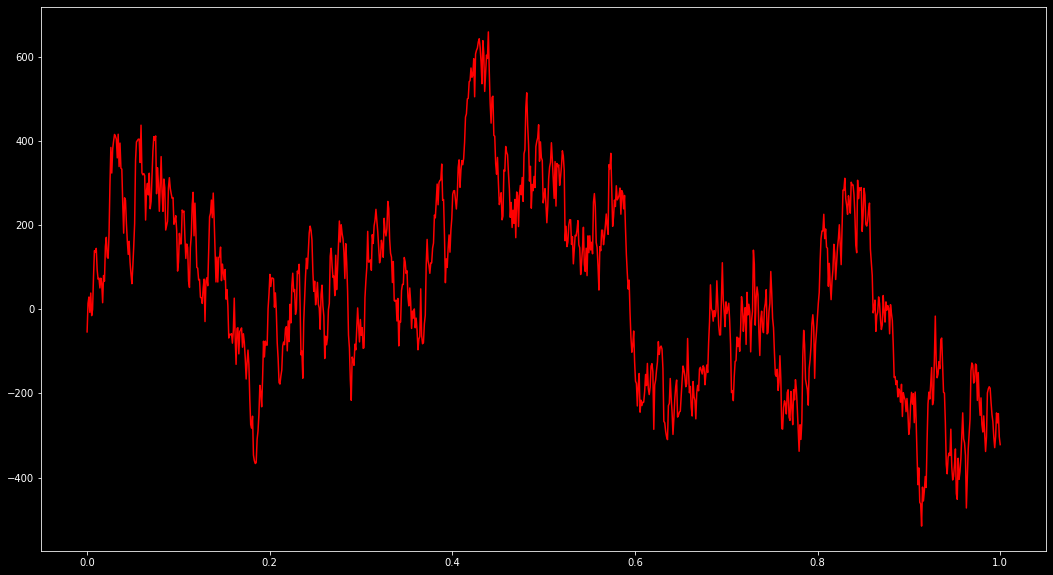

In [8]:
cis = Cov()
matrix = Structure().matrix(cis)
simu = GaussianProcess(matrix, cis)
gp = simu.simulate_gaussian_process()
brm = simu.generateFBM(delta=10, gp=gp)
plt.style.use('dark_background')
plt.figure(figsize=(18, 10))
plt.plot(np.linspace(0, 1, 1000), brm, color='red')

In [2]:
# sample Fractional brownian motion with H 
def generate_fractional_brownian_motion(H_values, uniform_samples_size):
    if len(H_values) == 0:
        return 
    families = {}
    for h in H_values:
        cis = Cov(h=h)
        matrix = Structure(sample_size=uniform_samples_size).matrix(cis)
        simu = GaussianProcess(matrix, cis)
        gp = simu.simulate_gaussian_process()
        brm = simu.generateFBM(delta=10, gp=gp)
        families[h] = brm
    return families 




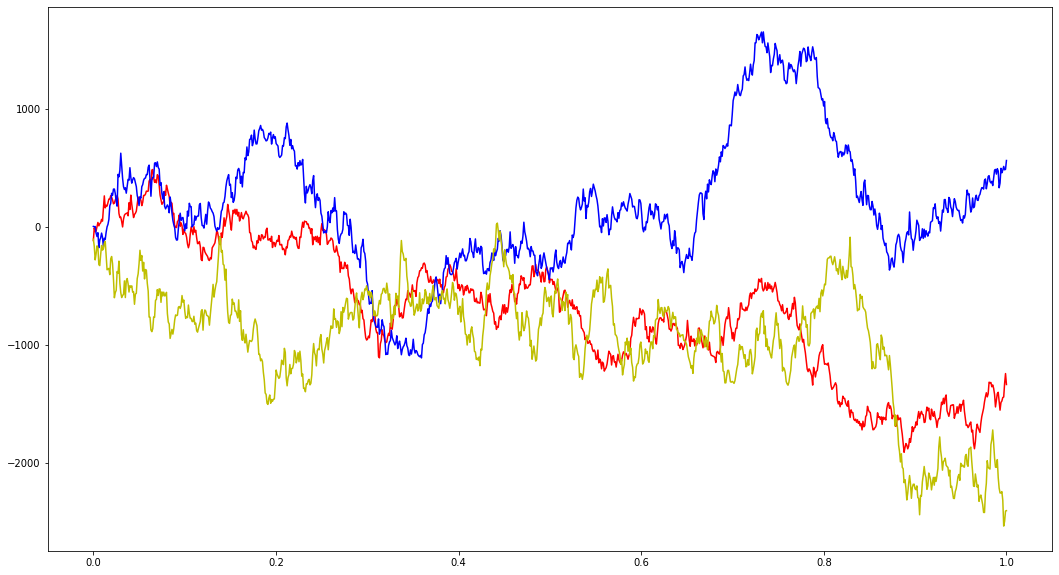

In [3]:
tests = generate_fractional_brownian_motion(
    H_values=[.2, .3, .4],
    uniform_samples_size=1000)
colors = ['r', 'b', 'y']
k = 0
plt.figure(figsize=(18, 10))
for samples in tests:
    plt.plot(np.linspace(0, 1, 1000), tests[samples], color=colors[k])
    k += 1